### Importing GT

In [1]:
import json
import numpy as np
from scipy.spatial.transform import Rotation as R

In [2]:
def create_obb_from_description(centroid, dimensions, rotations):
    # Extract centroid, dimensions, and rotations
    cx, cy, cz = centroid["x"], centroid["y"], centroid["z"]
    length, width, height = dimensions["length"], dimensions["width"], dimensions["height"]
    rx, ry, rz = rotations["x"], rotations["y"], rotations["z"]

    # Create the 8 corners of the box before rotation and translation
    dx = length / 2
    dy = width / 2
    dz = height / 2

    corners = np.array([
        [-dx, -dy, -dz],
        [ dx, -dy, -dz],
        [ dx,  dy, -dz],
        [-dx,  dy, -dz],
        [-dx, -dy,  dz],
        [ dx, -dy,  dz],
        [ dx,  dy,  dz],
        [-dx,  dy,  dz]
    ])

    # Apply rotations
    rotation = R.from_euler('xyz', [rx, ry, rz], degrees=True)
    rotated_corners = rotation.apply(corners)

    # Apply translation (centroid)
    translated_corners = rotated_corners + np.array([cx, cy, cz])

    return translated_corners

In [3]:
gt = json.load(open('../labelCloud/labels/rtabmap_cloud.json'))
for obj in gt['objects']:
    obj['bbox'] = create_obb_from_description(obj['centroid'], obj['dimensions'], obj['rotations']).tolist()

In [4]:
predictions = json.load(open('predictions.json'))
predicted_objects = predictions['objects']

for obj in predicted_objects:
    obj['bbox'] = np.array(obj['OBB']).reshape(8, 3)
    obj['points'] = np.array(obj['points']).reshape(-1, 3)

## Visualize PC and BBoxes

In [6]:
import open3d as o3d
PC_PATH = '../labelCloud/pointclouds/rtabmap_cloud.ply'

# Load the point cloud from a .ply file
pcd = o3d.io.read_point_cloud(PC_PATH)

In [7]:
class Obj:
    def __init__(self, label, bbox):
        assert isinstance(label, str)
        assert isinstance(bbox, o3d.geometry.OrientedBoundingBox)
        self.label = label
        self.bbox = bbox  # instance of o3d.geometry.OrientedBoundingBox


class Gt_Obj(Obj):
    def __init__(self, label, bbox):
        super().__init__(label, bbox)
        self.points = None
        self.centroid = np.mean(bbox.get_box_points(), axis=0)

class Pred_Obj(Obj):
    def __init__(self, label, bbox, points):
        super().__init__(label, bbox)
        self.points = points
        self.centroid = np.mean(points, axis=0)


class ObjList:
    def __init__(self, objects: list):
        assert isinstance(objects, list)
        assert all(isinstance(obj, Obj) for obj in objects)
        self.objects = objects

    def __getitem__(self, key):
        return self.objects[key]

    def __len__(self):
        return len(self.objects)

    def get_boxes_list(self):
        return [obj.bbox for obj in self.objects]

In [8]:
# Load GT bboxes
gt_boxes = []
for obj in gt["objects"]:
    v = o3d.utility.Vector3dVector(obj["bbox"])
    bbox = o3d.geometry.OrientedBoundingBox.create_from_points(v)
    bbox.color = [0, 1, 0]
    gt_boxes.append(Gt_Obj(obj["name"], bbox))

# Load predicted bboxes
pred_boxes = []
for obj in predicted_objects:
    bbox = np.array(obj["OBB"]).reshape(8, 3)
    v = o3d.utility.Vector3dVector(bbox)
    if np.sum(bbox) == 0:
        continue
    try:
        bbox = o3d.geometry.OrientedBoundingBox.create_from_points(v)
        bbox.color = [1, 0, 0]
        pred_boxes.append(Pred_Obj(obj["label"], bbox, obj["points"]))
    except:
        pass

gt_objects = ObjList(gt_boxes)
pred_objects = ObjList(pred_boxes)

In [9]:
def custom_draw_geometry(pcd, gt_objects, pred_objects):
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(pcd)

    for obj in gt_objects:
        vis.add_geometry(obj.bbox)

    for obj in pred_objects:
        vis.add_geometry(obj.bbox)

    vis.run()
    vis.destroy_window()

In [10]:
custom_draw_geometry(pcd, gt_objects, pred_objects)

In [10]:
def compute_3d_iou(box1, box2):
    """
    Compute the Intersection over Union (IoU) of two 3D boxes.

    Parameters:
    - box1: (8, 3) numpy array of vertices for the first box.
    - box2: (8, 3) numpy array of vertices for the second box.

    Returns:
    - float: the IoU of the two boxes.
    """
    # Extract the min and max points
    min_point1 = np.min(box1, axis=0)
    max_point1 = np.max(box1, axis=0)
    min_point2 = np.min(box2, axis=0)
    max_point2 = np.max(box2, axis=0)

    # Calculate intersection bounds
    inter_min = np.maximum(min_point1, min_point2)
    inter_max = np.minimum(max_point1, max_point2)
    inter_dims = np.maximum(inter_max - inter_min, 0)

    # Intersection volume
    inter_volume = np.prod(inter_dims)

    # Volumes of the individual boxes
    volume1 = np.prod(max_point1 - min_point1)
    volume2 = np.prod(max_point2 - min_point2)

    # Union volume
    union_volume = volume1 + volume2 - inter_volume

    # Intersection over Union
    iou = inter_volume / union_volume if union_volume != 0 else 0

    return iou

In [46]:
import matplotlib.pyplot as plt


# Associating GT and predicted objects
def compute_3d_iou_matrix(gt_boxes, pred_boxes):
    """
    Compute the 3D IoU matrix between GT and predicted objects.

    Parameters:
    - gt_boxes: list of GT OrientedBoundingBox objects.
    - pred_boxes: list of predicted OrientedBoundingBox objects.

    Returns:
    - numpy array: 2D array where element (i, j) is the IoU between GT object i and predicted object j.
    """
    iou_matrix = np.zeros((len(gt_boxes), len(pred_boxes)))
    for i, gt_box in enumerate(gt_boxes):
        for j, pred_box in enumerate(pred_boxes):
            iou_matrix[i, j] = compute_3d_iou(
                np.array(gt_box.get_box_points()), np.array(pred_box.get_box_points())
            )
    return iou_matrix


def get_matches(gt_objects, pred_objects, iou_threshold=0.5):
    """
    Get the matched GT and predicted objects.
    returns:
     - matched_couples: list of dictionaries containing the matched GT and predicted objects and their IoU.
     - phantom_predictions: list of predicted objects that have no match.
     - missed_gt: list of GT objects that have no match.
    """

    gt_boxes = gt_objects.get_boxes_list()
    pred_boxes = pred_objects.get_boxes_list()
    iou_matrix = compute_3d_iou_matrix(gt_boxes, pred_boxes)

    matches = []
    for i, j in zip(*np.where(iou_matrix > iou_threshold)):
        matches.append({"gt": i, "pred": j, "iou": iou_matrix[i, j]})
    matches = sorted(matches, key=lambda x: x["iou"], reverse=True)

    matched_gt = set()
    matched_preds = set()
    matched_couples = []
    for match in matches:
        if match["gt"] not in matched_gt and match["pred"] not in matched_preds:
            matched_gt.add(match["gt"])
            matched_preds.add(match["pred"])
            matched_couples.append(
                {
                    "gt": gt_objects[match["gt"]],
                    "pred": pred_objects[match["pred"]],
                    "iou": match["iou"],
                }
            )

    phantom_preds = [pred_objects[i] for i in range(len(pred_objects)) if i not in matched_preds]
    missed_gt = [gt_objects[i] for i in range(len(gt_objects)) if i not in matched_gt]

    ious = [match["iou"] for match in matched_couples]
    assert len(ious) == len(set(ious))
    assert len(matched_couples) + len(phantom_preds) == len(pred_objects)
    assert len(matched_couples) + len(missed_gt) == len(gt_objects)

    return matched_couples, phantom_preds, missed_gt

matching, phantom_preds, missed_gt = get_matches(gt_objects, pred_objects, 0.80)

In [32]:
custom_draw_geometry(pcd, ObjList(phantom_preds), ObjList(missed_gt))

In [47]:
len(matching), len(phantom_preds), len(missed_gt)

(1, 31, 17)

In [35]:
ious = [match["iou"] for match in matching]
np.mean(ious)

0.7119326029687233

In [36]:
# compute precision, recall, f1

def compute_metrics(gt_objects, pred_objects, iou_threshold = 0.1, iou_avg_method=np.mean):
    """
    Computes: accuracy, precision, recall, F1 score and avg_iou (for matched_couples).
    matches: list of dictionaries containing the matched GT and predicted objects.
    missed_gt: number of GT objects that have no match.
    phantom_pred: number of predicted objects that have no match.
    """
    matches, phantom_pred, missed_gt = get_matches(gt_objects, pred_objects, iou_threshold)
    correct_matches = sum([match['gt'].label == match['pred'].label for match in matches])
    non_correct_matches = len(matches) - correct_matches
    avg_iou = iou_avg_method([match['iou'] for match in matches])

    TP = correct_matches
    FP = len(phantom_pred) + non_correct_matches
    FN = len(missed_gt)

    accuracy = TP / (TP + FP + FN)
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    recall = TP / (TP + FN) if TP + FN != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0

    return accuracy, precision, recall, f1, avg_iou

compute_metrics(gt_objects, pred_objects)

(0.3157894736842105,
 0.375,
 0.6666666666666666,
 0.4800000000000001,
 0.46821079405023663)

In [68]:
def compute_average_precision(gt_objects, pred_objects, iou_thresholds=np.linspace(0, 0.9, 9)):
    precisions = []
    recalls = []

    for threshold in iou_thresholds:
        _, precision, recall, _, _ = compute_metrics(gt_objects, pred_objects, iou_threshold=threshold)
        precisions.append(precision)
        recalls.append(recall)

    # Sort by recall to integrate
    recall_precision_pairs = sorted(zip(recalls, precisions), key=lambda x: x[0])
    recalls_sorted, precisions_sorted = zip(*recall_precision_pairs)

    # Compute average precision using the trapezoidal rule
    average_precision = np.trapz(precisions_sorted, recalls_sorted)

    return average_precision, recalls_sorted, precisions_sorted

# Example usage
average_precision, recalls, precisions = compute_average_precision(gt_objects, pred_objects)
print(f"AP: {average_precision}")

AP: 0.21599264705882354


/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


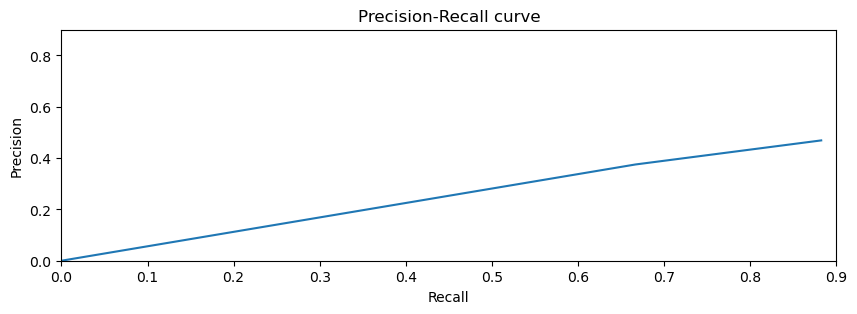

In [89]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(recalls, precisions)
ax.set_xlim([0, 0.9])
ax.set_ylim([0, 0.9])
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall curve")
plt.show()